In [23]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Packages for feature engineering
from sklearn.model_selection import train_test_split, StratifiedKFold,cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,\
                            recall_score, f1_score, roc_auc_score, classification_report,\
                            roc_curve, auc
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

In [5]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# **Heatmap**

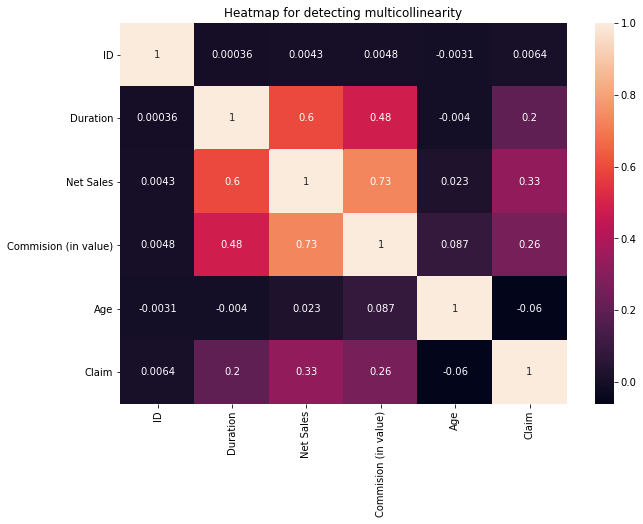

In [6]:
fig = plt.figure(figsize=(10, 7))
sns.heatmap(df_train.corr(), annot=True)
plt.title('Heatmap for detecting multicollinearity')
plt.show()

# **Feature Engineering**

In [6]:
# # Converting Age >100 to mean value
# df_train['Age'] = df_train.groupby('Claim')['Age'].transform(lambda x: np.where(x > 100, x.mean(), x))

# # Converting duration<0 to mean value 
# df_train['Duration'] = df_train.groupby('Claim')['Duration'].transform(lambda x: np.where(x <0, x.mean(), x))

In [7]:
# covert all catogorical data into numeric data
from sklearn.preprocessing import LabelEncoder

for column in df_train.columns:
  if df_train[column].dtype == np.number:
    continue
  df_train[column] = LabelEncoder().fit_transform(df_train[column])

# **Feature Selection**

In [8]:
x = df_train.drop('Claim',axis=1) # feature data set

y=df_train['Claim']

# split the data into (70%)train and (30%)test
X_train ,X_test ,y_train, y_test = train_test_split(x , y ,test_size =0.3, random_state=42)


In [9]:
def plot_cm(classifier, predictions):
    cm = confusion_matrix(y_test, predictions)
    
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap='RdBu')
    classNames = ['Normal','Fraud']
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), 
                     horizontalalignment='center', color='White')
    
    plt.show()
        
    tn, fp, fn, tp = cm.ravel()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    F1 = 2*recall*precision/(recall+precision)

    print('Recall={0:0.3f}'.format(recall),'\nPrecision={0:0.3f}'.format(precision))
    print('F1={0:0.3f}'.format(F1))

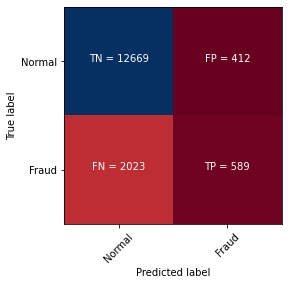

Recall=0.225 
Precision=0.588
F1=0.326
0.22549770290964777


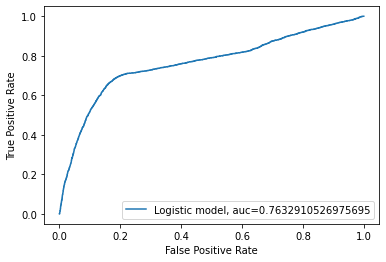

In [10]:
# parameters for grid search
parameters = {'C':[0.1,0.5,1,5]}

# Code starts here

# instantiate logistic regression model
lr=LogisticRegression(random_state=9)
lr.fit(X_train,y_train)
# grid search on logistic regression

grid = GridSearchCV(estimator=lr, param_grid=parameters)
grid.fit(X_train, y_train)

# make predictions 
y_pred = grid.predict(X_test)
precision= precision_score(y_pred,y_test)
plot_cm(grid, y_pred)
print(precision)

# Plot the auc-roc curve
score = roc_auc_score(y_pred , y_test)
y_pred_proba = lr.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Logistic model, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

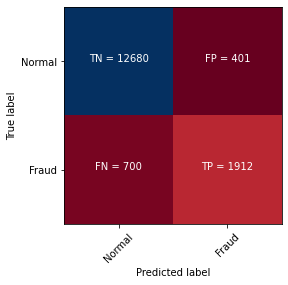

Recall=0.732 
Precision=0.827
F1=0.776
0.9298413305295354


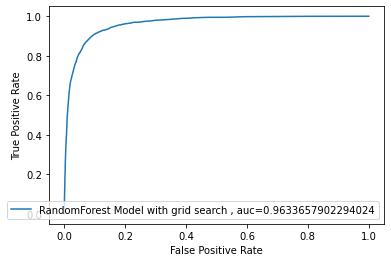

In [11]:
#Random forest with GridSearchCV
parameters = {'n_estimators':[500]}
# instantiate random forest model
rf= RandomForestClassifier()
rf.fit(X_train,y_train)

# grid search on random forest classifier 

grid_rf = GridSearchCV(estimator=rf, param_grid=parameters)
grid_rf.fit(X_train, y_train)

# make predictions 
y_pred_rf = grid_rf.predict(X_test)
precision_rf= accuracy_score(y_pred_rf,y_test)

plot_cm(grid_rf, y_pred_rf)
print(precision_rf)

# Plot the auc-roc curve
score = roc_auc_score(y_pred_rf , y_test)
y_pred_proba = grid_rf.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="RandomForest Model with grid search , auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

**Effect of Class Wt. in Imbalanced Classes**

**Featue Engineering**

In [12]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [13]:
# Converting Age >100 to mean value
train['Age'] = df_train.groupby('Claim')['Age'].transform(lambda x: np.where(x > 100, x.mean(), x))

# Converting duration<0 to mean value 
train['Duration'] = df_train.groupby('Claim')['Duration'].transform(lambda x: np.where(x <0, x.mean(), x))

In [14]:
categorical_columns = [c for c in train.columns 
                       if train[c].dtype.name == 'object']
numerical_columns = [c for c in train.columns 
                     if train[c].dtype.name != 'object']

print('categorical_columns:', categorical_columns)
print('numerical_columns:', numerical_columns)

categorical_columns: ['Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Destination']
numerical_columns: ['ID', 'Duration', 'Net Sales', 'Commision (in value)', 'Age', 'Claim']


In [15]:
#converting categorical variables to numerical
le = LabelEncoder()

for x in categorical_columns:
    train[x] = le.fit_transform(train[x])

In [16]:
X = train.iloc[:,:-1]
y = train['Claim']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

F1 score: 0.7688253012048193
Precision: 0.8403292181069959
Recall: 0.7085357390700903
ROC Score: 0.8407778479788252
Confusion Matrix:
 [[13993   388]
 [  840  2042]]


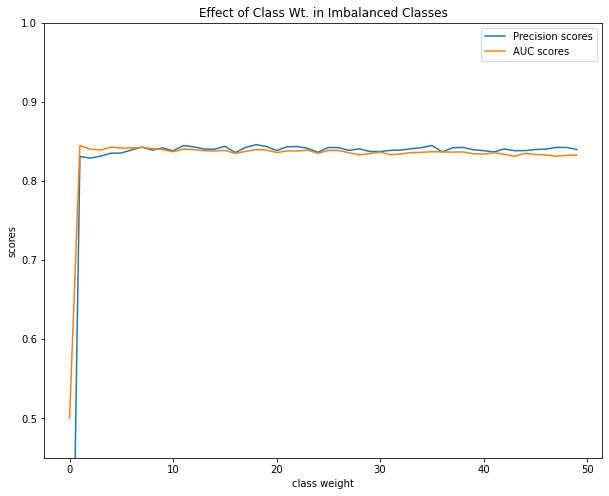

In [17]:
# Creating list of class weights
class_wts = range(50)

prs = []
auc = []
#Loop to iterate different weights to the minority class(1) 
for wt in class_wts:
    rf7 = RandomForestClassifier(random_state=0, class_weight={0:1,1:wt})
    rf7.fit(X_train, y_train)
    prs.append(precision_score(y_test, rf7.predict(X_test)))
    auc.append(roc_auc_score(y_test, rf7.predict(X_test)))


#Selecting the max f1 score    
max_scorer = prs.index(np.max(prs))

#Selecting the model with the max score
rf7 = RandomForestClassifier(random_state=9, class_weight={0:1,1:max_scorer})
rf7.fit(X_train, y_train)

print ("F1 score:", f1_score(y_test, rf7.predict(X_test)))
print ("Precision:",precision_score(y_test, rf7.predict(X_test)))
print ("Recall:",recall_score(y_test, rf7.predict(X_test)))
print ("ROC Score:",roc_auc_score(y_test, rf7.predict(X_test)))
print ("Confusion Matrix:\n",confusion_matrix(y_test, rf7.predict(X_test)))

plt.figure(figsize=(10, 8))
plt.plot(class_wts, prs, label="Precision scores")
plt.plot(class_wts, auc, label="AUC scores")
plt.xlabel("class weight")
plt.ylabel("scores")
plt.title("Effect of Class Wt. in Imbalanced Classes")
plt.ylim(0.45,1)
plt.legend()
plt.show()

**Over Sampling with SMOTE**

In [18]:
smote = SMOTE(random_state=0)
#Fitting and transforming data points
X_sample, y_sample = smote.fit_sample(X_train, y_train)

## Random Forest Classifier

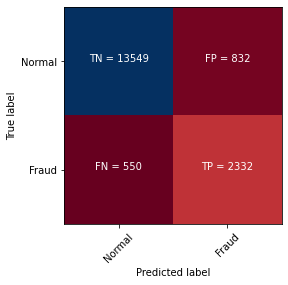

Recall=0.809 
Precision=0.737
F1=0.771
precision is : 0.7370417193426043
acuracy is : 0.9199443897352719
recall is : 0.8091603053435115
f1 score is : 0.7714191200793914


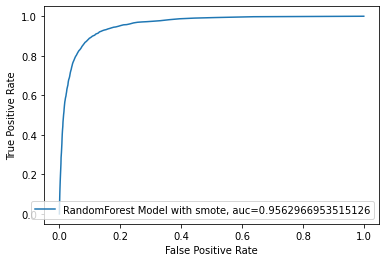

In [19]:
rf_smote=RandomForestClassifier(random_state=0)
rf_smote.fit(X_sample,y_sample)
y_pred_smote= rf_smote.predict(X_test)
accuracy_smote= rf_smote.score(X_test,y_test)
recall_smote= recall_score(y_test,y_pred_smote)
precision_smote= precision_score(y_test,y_pred_smote)
f1_smote= f1_score(y_test,y_pred_smote)

#plots
plot_cm(rf_smote, y_pred_smote)
#After Sampling    
print("precision is :",precision_smote)
print("acuracy is :",accuracy_smote)
print("recall is :",recall_smote)
print("f1 score is :",f1_smote)

# Plot the auc-roc curve
score = roc_auc_score(y_pred_smote , y_test)
y_pred_proba = rf_smote.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="RandomForest Model with smote, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

## **Ensemble technique-GradientBoosting with  AdaBoost**

In [20]:
X = train.iloc[:,:-1]
y = train['Claim']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [21]:
gbc = GradientBoostingClassifier(n_estimators=100)
gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict(X_test)
precision_gbc=precision_score(y_test, y_pred_gbc)
print("Precision is ",precision_gbc)
print(classification_report(y_test, y_pred_gbc))

Precision is  0.6502890173410405
              precision    recall  f1-score   support

           0       0.89      0.96      0.92     14381
           1       0.65      0.39      0.49      2882

    accuracy                           0.86     17263
   macro avg       0.77      0.67      0.70     17263
weighted avg       0.85      0.86      0.85     17263



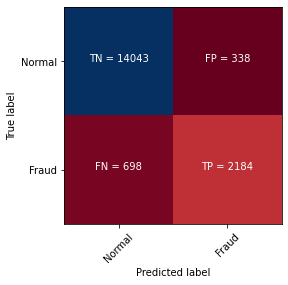

Recall=0.758 
Precision=0.866
F1=0.808
precision is : 0.865979381443299
acuracy is : 0.9399872559809999
recall is : 0.7578070784177654
f1 score is : 0.8082901554404146


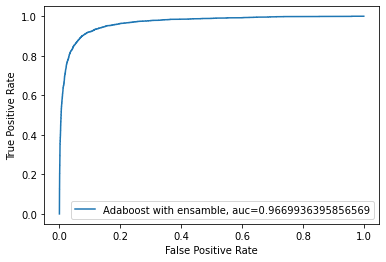

In [22]:
adc = AdaBoostClassifier(base_estimator = gbc, n_estimators=100)
adc.fit(X_train, y_train)
y_pred_adc = adc.predict(X_test)
accuracy_en=adc.score(X_test,y_test)
recall_en= recall_score(y_test,y_pred_adc)
precision_en= precision_score(y_test,y_pred_adc)
f1_en= f1_score(y_test,y_pred_adc)

#plots
plot_cm(adc, y_pred_adc)
#After Sampling    
print("precision is :",precision_en)
print("acuracy is :",accuracy_en)
print("recall is :",recall_en)
print("f1 score is :",f1_en)

# Plot the auc-roc curve
score = roc_auc_score(y_pred_adc , y_test)
y_pred_proba = adc.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Adaboost with ensamble, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()